# Subgroup and Instantaneous Fairness

This notebook demonstrates the usage of the subgroup fairness and instantaneous fairness post processing methods.

These methods are derived from the 'Fairness in Forecasting of Observations of Linear Dynamical Systems' paper by Quan Zhou, et al. The paper can be found at https://www.jair.org/index.php/jair/article/view/14050. 

Subgroup fairness and instantaneous fairness are two notions of fairness introduced to address under-representation bias when learning forecasting models from imbalanced time series data. 

**Subgroup fairness** seeks to equalize the total loss for each subgroup over the entire time period. The optimisation problem for subgroup fairness is as follows:

**Instantaneous fairness**, on the other hand, seeks to equalize the maximum instantaneous loss across all subgroups at each time step. The optimisation problem for instantaneous fairness is as follows:

In [1]:
# Load all necessary packages
import sys
sys.path.append("../")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aif360.datasets import CompasDataset
from humancompatible.repair.postprocess.lds_fairness import SubgroupFairOptimiser, InstantaneousFairOptimiser

The COMPAS dataset is used to demonstrate the usage of subgroup and instantaneous fairness.

In [2]:
def load_compas_dataset(s,u,u_cat,x,y):
    def custom_preprocessing(df):
        df=df[(df["race"]=='African-American')|(df["race"]=='Caucasian')]
        mask = (df.days_b_screening_arrest <= 30) & \
               (df.days_b_screening_arrest >= -30) & \
               (df.is_recid != -1) & \
               (df.c_charge_degree != 'O') & \
               (df.score_text != 'N/A')
        df = df.loc[mask].copy()
        charge_degree_map = {'M': 0, 'F': 1} 
        df['c_charge_degree'] = df['c_charge_degree'].map(charge_degree_map)
        df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)
        df['sex'] = df['sex'].apply(lambda x:1 if x == "Female" else 0)       
        df['priors_total_count'] = (df['juv_fel_count'] + df['juv_misd_count'] + df['priors_count']) / 3
        df['age_under_25'] = df['age'].apply(lambda x:1 if x < 25 else 0)
        return df

    compas = CompasDataset(
        label_name=y,
        favorable_classes=[1],
        protected_attribute_names=[s],
        privileged_classes=[[1]],
        instance_weights_name=None,
        categorical_features=u_cat,
        features_to_keep=[s]+u+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        metadata={}
    )
    return compas

This class can be used to calculate various performance metrics based on the original dataset, and the repaired dataset. The performance metrics include:
- **IND:** absolute difference in negative prediction rates
- **SP:** sum of absolute differences in false positive and false negative rates
- **SF:** sum of absolute differences in positive and negative predictive values
- **INA:** inaccuracy of the model's predictions

In [3]:
class LDS_Fairness_Evaluator:
    def __init__ (self,S, Y_hat):
        self.S = S
        self.Y_hat = Y_hat

    def evaluate(self, dataset_orig, dataset_repaired):
        D_orig = dataset_orig.convert_to_dataframe()[0]
        D_repaired = dataset_repaired#.convert_to_dataframe()[0]
        
        D_privileged_orig, D_unprivileged_orig = self._split_data(D_orig)
        D_privileged_repaired, D_unprivileged_repaired = self._split_data(D_repaired)
        
        Y_hat_orig_privileged = D_privileged_orig[self.Y_hat]
        Y_hat_orig_unprivileged = D_unprivileged_orig[self.Y_hat]
        Y_hat_repaired_privileged = D_privileged_repaired[self.Y_hat]
        Y_hat_repaired_unprivileged = D_unprivileged_repaired[self.Y_hat]

        perf_privileged = self.calculate_performance_metrics(Y_hat_orig_privileged, Y_hat_repaired_privileged)
        perf_unprivileged = self.calculate_performance_metrics(Y_hat_orig_unprivileged, Y_hat_repaired_unprivileged)
        
        metrics = {
            "IND": abs(perf_unprivileged[0] - perf_privileged[0]), # Independent difference
            "SP": abs(perf_unprivileged[1] - perf_privileged[1] + abs(perf_privileged[2] - perf_unprivileged[2])), # Separation
            "SF": abs(perf_unprivileged[3] - perf_privileged[3] + abs(perf_unprivileged[4] - perf_privileged[4])), # Sufficiency
            "INA": (perf_unprivileged[5] + perf_privileged[5]) / (len(D_orig)) # Inaccuracy
        }

        return metrics

    def calculate_performance_metrics(self, Y_hat_orig, Y_hat_repaired):
        TP = np.sum((Y_hat_orig == 1) & (Y_hat_repaired == 1))
        TN = np.sum((Y_hat_orig == 0) & (Y_hat_repaired == 0))
        FP = np.sum((Y_hat_orig == 0) & (Y_hat_repaired == 1))
        FN = np.sum((Y_hat_orig == 1) & (Y_hat_repaired == 0))
        
        NR = (TN+FN)/(len(Y_hat_orig))
        FPR = FP/(FP+TN+1e-10)
        FNR = FN/(FN+TP+1e-10)
        PPV = TP/(TP+FP+1e-10)
        NPV = TN/(TN+FN+1e-10)
        inACC = FP+FN
        return [NR, FPR, FNR, PPV, NPV, inACC]

    def _split_data(self, dataset):
        D_privileged = dataset[dataset[self.S] == 1]
        D_unprivileged = dataset[dataset[self.S] == 0]
        return D_privileged, D_unprivileged

## Parameters for Distributional Repair Algorithm
 
- `S` is the protected or sensitive attribute for which the repair is against

- `U` are any other attributes that are not used in the repair, but are to still be loaded in the dataset

- `U_categorical` is a list of categorical features, in addition to `U`

- `X` is a list of features used by the algorithm to repair the model. These cannot be sensitive attributes.

- `Y_hat` is the predicted label

- `solver_path` *(optional)*. For the best results, the SPDA solver can be used. Download it from https://sdpa.sourceforge.net/ and provide the path to the solver. If not provided, the default CVXOPT solver will be used, although it may not be as accurate and will take considerably longer to run.

In [4]:
S = 'race'
U = ['sex', 'age']
U_categorical = ['age_cat','c_charge_degree']
X = ['age_under_25','priors_total_count','decile_score']
Y_hat = 'is_recid'
# solver_path="../sdpa.exe"
solver_path=None

## Step 1: Split the data into training and testing sets
The dataset is split into a training and testing set. The training set is used to construct the min-max optimisation in order to minimise loss, and generate variables by which to reweigh the data. The testing set is used to evaluate the performance of the model.

In [5]:
split = 0.2
compas = load_compas_dataset(S, U, U_categorical, X, Y_hat)
data_train, data_test = compas.split([split], shuffle=True)

## Step 2: Initialise the model
The implementation of the subgroup and instantaneous fairness methods is identiacal, with both classes inheriting from the baseLDS class. The model is initialised with the following parameters:
- `S`
- `X`
- `Y_hat`
- `solver_path` *(optional)*

In [6]:
subgroup_fair_optimiser = SubgroupFairOptimiser(S, X, Y_hat,solver_path=solver_path)
instantaneous_fair_optimiser = InstantaneousFairOptimiser(S, X, Y_hat,solver_path=solver_path)

## Step 3: Fit the model

Using the training data, the model is fit to the data. The will apply the following optimisation problem to the data:

### Subgroup Fairness
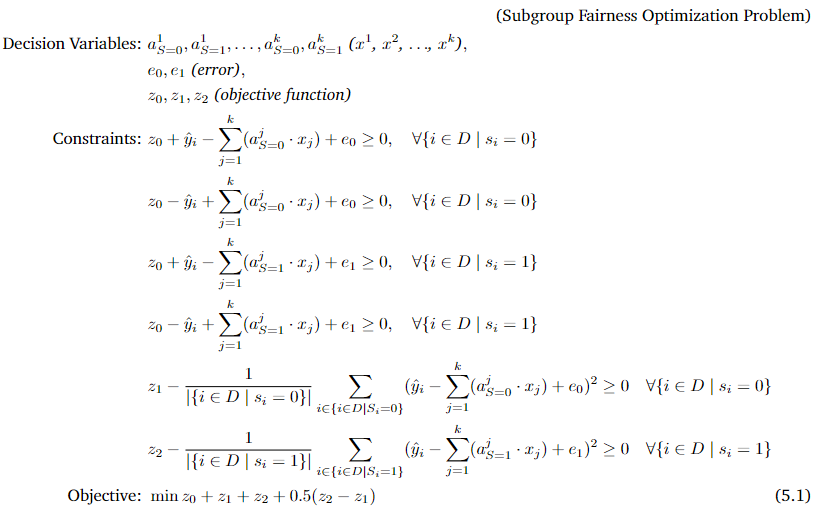

### Instantaneous Fairness
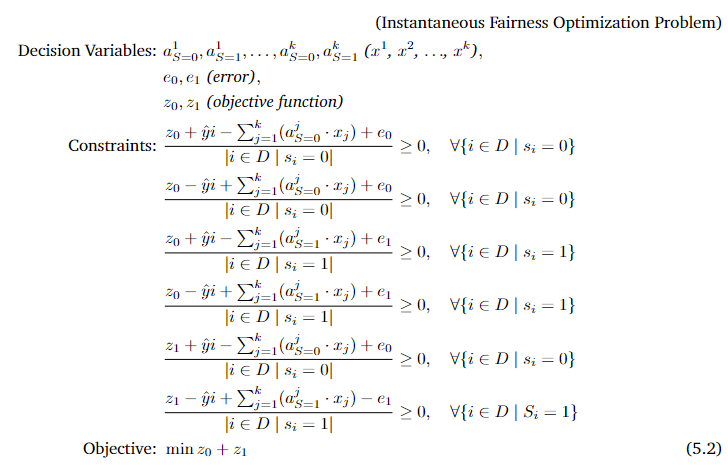

In [7]:
subgroup_fair_optimiser = subgroup_fair_optimiser.fit(data_train.copy())
print("Subgroup Fair Optimiser trained")
instantaneous_fair_optimiser = instantaneous_fair_optimiser.fit(data_train.copy())
print("Instantaneous Fair Optimiser trained")

Subgroup Fair Optimiser trained
Instantaneous Fair Optimiser trained


## Step 4: Transform the data

The training data can now be reweighed using the solved decision variables from the optimisation problem. A base rate from the original data is applied in order to keep the number of favourable and unfavourable outcomes similar. The data is transformed using the following equation:

In [8]:
subgroup_repaired = subgroup_fair_optimiser.transform(data_test.copy())
print("Subgroup Fair Optimiser repaired")
instantaneous_repaired = instantaneous_fair_optimiser.transform(data_test.copy())
print("Instantaneous Fair Optimiser repaired")

Subgroup Fair Optimiser repaired
Instantaneous Fair Optimiser repaired


## Evaluating the repair algorithms

Using the previously defined evaluator, we can now evaluate the performance of the repair algorithms. Lower scores are better for all metrics.

In [9]:
evaluator = LDS_Fairness_Evaluator(S, Y_hat)
subgroup_repaired_metrics = evaluator.evaluate(data_test.copy(), subgroup_repaired.copy())
print("Subgroup Fair Optimiser evaluated")
print(subgroup_repaired_metrics)
instantaneous_repaired_metrics = evaluator.evaluate(data_test.copy(), instantaneous_repaired.copy())
print("Instantaneous Fair Optimiser evaluated")
print(instantaneous_repaired_metrics)

Subgroup Fair Optimiser evaluated
{'IND': np.float64(0.10450833824879974), 'SP': np.float64(0.12855516197711495), 'SF': np.float64(0.23098628401796428), 'INA': np.float64(0.3592233009708738)}
Instantaneous Fair Optimiser evaluated
{'IND': np.float64(0.3494261970716264), 'SP': np.float64(0.249169699944503), 'SF': np.float64(0.8541678526933385), 'INA': np.float64(0.4489699265924698)}


## Plotting the results

The plot below demonstrates how the metrics from the evaluator can be visualised, and shows the performance of the case used in this demo file.

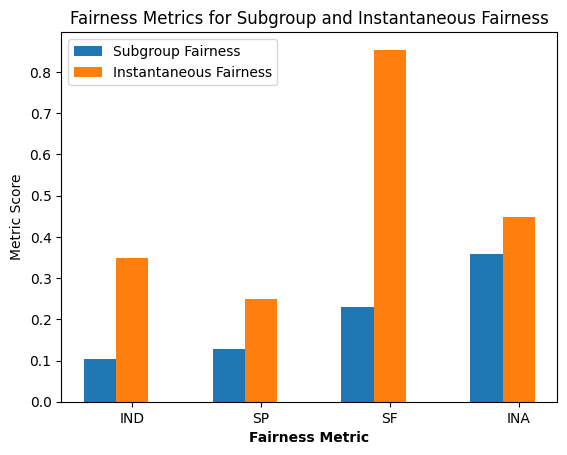

In [10]:
#plot the results
fig, ax = plt.subplots()
barWidth = 0.25
bars1 = [subgroup_repaired_metrics["IND"], subgroup_repaired_metrics["SP"], subgroup_repaired_metrics["SF"], subgroup_repaired_metrics["INA"]]
bars2 = [instantaneous_repaired_metrics["IND"], instantaneous_repaired_metrics["SP"], instantaneous_repaired_metrics["SF"], instantaneous_repaired_metrics["INA"]]
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
plt.bar(r1, bars1, color='tab:blue', width=barWidth, label='Subgroup Fairness')
plt.bar(r2, bars2, color='tab:orange', width=barWidth, label='Instantaneous Fairness')
plt.xlabel('Fairness Metric', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['IND', 'SP', 'SF', 'INA'])
plt.legend()
plt.ylabel('Metric Score')
plt.title('Fairness Metrics for Subgroup and Instantaneous Fairness')
plt.show()